# Аналитика в Яндекс.Афише

## <a name="0.0"></a>Содержание:

* [0. Описание проекта, описание данных, загрузка и импорт библиотек](#0.)

* [Шаг 1. Загрузим данные и подготовимся к их анализу](#1.)
  
* [Шаг 2. Постройте отчёты и посчитайте метрики.](#2.)
* [2.1 Продукт](#2.1)
     - [2.1.1 Сколько людей пользуются в день, неделю, месяц?](#2.1.1)
     - [2.1.2 Сколько сессий в день?](#2.1.2)
     - [2.1.3 Сколько длится одна сессия?](#2.1.3)
     - [2.1.4 Как часто люди возвращаются?](#2.1.4)
* [2.2 Продажи](#2.2)
     - [2.2.1 Когда люди начинают покупать?](#2.2.1)
     - [2.2.2 На каком по счету визите люди начинают покупать?](#2.2.2)
     - [2.2.3 Сколько раз покупают за период?](#2.2.3)
     - [2.2.4 Какой средний чек?](#2.2.4)
     - [2.2.5 Сколько денег приносят? (LTV)](#2.2.5)
* [2.3 Маркетинг](#2.3)
     - [2.3.1 Сколько денег потратили? Всего / на каждый источник / по времени ](#2.3.1)
     - [2.3.2 Сколько стоило привлечение одного покупателя из каждого источника?](#2.3.2)
     - [2.3.3 На сколько окупились расходы? (ROI)](#2.3.3)
     - [2.3.4 Анализ платформ](#2.3.4)
* [Шаг 3. Выводы](#3.)

### Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.
У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
лог сервера с данными о посещениях сайта Яндекс.Афиши,
выгрузка всех заказов за этот период,
статистика рекламных расходов.

Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. 

Вы изучите:
как люди пользуются продуктом,
когда они начинают покупать,
сколько денег приносит каждый клиент
когда клиент окупается.

<a name="1."></a><br/>
<font size="5"><b>1. Загрузим данные и подготовимся к их анализу</b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

In [1]:
import time
start_1 = time.time()
# импорт библиотеки pandas
import pandas as pd 
# библиотеки для визуализации
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
# импортируем библиотеки для мат.расчетов
import random
import math
import numpy as np
import copy
from scipy import stats as st

Для знакомства данными, выведем на экран первые 5 строк таблицы.

In [2]:
visits=pd.read_csv('/datasets/visits_log.csv')
print(visits.info())
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Таблица visits (лог сервера с информацией о посещениях сайта):
* Uid — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Start Ts — дата и время начала сессии
* End Ts — дата и время окончания сессии
* Source Id — идентификатор рекламного источника, из которого пришел пользователь

In [3]:
orders=pd.read_csv('/datasets/orders_log.csv')
print(orders.info())
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Таблица orders (информация о заказах):
* Uid — уникальный id пользователя, который сделал заказ
* Buy Ts — дата и время заказа
* Revenue — выручка Яндекс.Афиши с этого заказа

In [4]:
costs=pd.read_csv('/datasets/costs.csv')
print(costs.info())
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Таблица costs (информация о затратах на маркетинг):
* source_id — идентификатор рекламного источника
* dt — дата
* costs — затраты на этот рекламный источник в этот день

In [5]:
# Проверка на дубли
print(visits.duplicated().sum())
print(costs.duplicated().sum())
print(orders.duplicated().sum())

0
0
0


Итак,таблицы прочитаны, сохранены, дублей нет.

Первая проблемма всех таблиц - неверный формат даты, вместо даты тип данных строка.

Вторая проблемма, это наименование столбцов. В разных таблицах одни и те же столбцы имеют разное написание, например, cost['source_id'] и visits['Source Id']. Нам ведь придесться их джоинить, поэтому, приведем все названия столбцов к единому формату написания(вместо пробелов - нижние подчеркивание, все буквы - строчные).
Исправим это поочередно для каждой из таблиц.

In [6]:
# меняем формат столбцов на дату
visits['End Ts']=visits['End Ts'].astype('datetime64')
visits['Start Ts']=pd.to_datetime(visits['Start Ts'])
# меняем названия столбцов
visits.set_axis(['device','end_ts','source_id','start_ts','uid'],axis = 'columns',inplace = True)

In [7]:
# проверка
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


Формат и названия столбцов изменены успешно.
Сделаем тоже самое для таблиц costs и orders

In [8]:
# меняем формат столбцов на дату
orders['Buy Ts']=orders['Buy Ts'].astype('datetime64')
costs['dt']=pd.to_datetime(costs['dt'])
# меняем названия столбцов
orders.set_axis(['buy_ts','revenue','uid'],axis = 'columns',inplace = True)
costs=costs.rename(columns={'dt': 'date'})

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [10]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
date         2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


#### Формат и названия столбцов изменены успешно.

<a name="2."></a><br/>
<font size="5"><b>Шаг 2. Постройте отчёты и посчитайте метрики. </b></font>.<br/>
<a name="2.1"></a><br/>
<a name="2.1.1"></a><br/>
<font size="4"><b>2.1.1 Ответим на вопрос сколько людей пользуются Яндекс.Афиша в день, неделю, месяц? </b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

Т.е. рассчитаем общепринятые названия следующих метрик:
* DAU (от англ. daily active users) — количество уникальных пользователей в день;
* WAU (от англ. weekly active users) — количество уникальных пользователей в неделю;
* MAU (от англ. monthly active users) — количество уникальных пользователей в месяц.

Чтобы посчитать недельное и месячное использование, выделим в отдельные столбцы год, месяц и неделю, а также полную дату, каждого посещения.

In [11]:
visits['year'] = visits['start_ts'].astype('datetime64[Y]')
visits['month']= visits['start_ts'].astype('datetime64[M]')
visits['week'] = visits['start_ts'].dt.week
visits['date'] = visits['start_ts'].astype('datetime64[D]')

In [12]:
visits.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,52,2017-12-27


In [13]:
dau_total = visits.groupby('date').agg({'uid': 'nunique'}).mean()
print('Среднее количество уникальных пользователей в день DAU =',int(dau_total.tolist()[0]))
wau_total = visits.groupby(['year','month','week']).agg({'uid': 'nunique'}).mean()
print('Среднее количество уникальных пользователей в неделю WAU =',int(wau_total.tolist()[0]))
mau_total = visits.groupby(['year','month']).agg({'uid': 'nunique'}).mean()
print('Среднее количество уникальных пользователей в месяц MAU =',int(mau_total.tolist()[0]))

Среднее количество уникальных пользователей в день DAU = 907
Среднее количество уникальных пользователей в неделю WAU = 4911
Среднее количество уникальных пользователей в месяц MAU = 23228


Как бонус к нашему проекту расчитаем sticky factor (англ. «липкий фактор»). 
Так можно посчитать регулярность использования нашего сайта — то, как часто пользователи к нему обращаются.

In [14]:
sticky_wau = (dau_total/wau_total).tolist()[0]
sticky_mau = (dau_total/mau_total).tolist()[0]
print('Недельный показатель возращения пользователей sticky_wau = {:.2%}'.format(sticky_wau))
print('Месячный показатель возращения пользователей sticky_mau = {:.2%}'.format(sticky_mau))

Недельный показатель возращения пользователей sticky_wau = 18.49%
Месячный показатель возращения пользователей sticky_mau = 3.91%


<a name="2.1.2"></a><br/>
<font size="4"><b>2.1.2 Сколько сессий в день?</b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

In [15]:
count_of_session__per_day = visits.groupby(['date']).agg({'start_ts': 'count'}).mean()
print('Среднее количество сессий в день =',int(count_of_session__per_day.tolist()[0]))

Среднее количество сессий в день = 987


<a name="2.1.3"></a><br/>
<font size="4"><b> 2.1.3 Сколько длится одна сессия?</b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

Средняя продолжительность сессии или ASL (англ. average session length) показывает, сколько длится сессия пользователя в среднем.

In [16]:
visits['duration_sec']=(visits['end_ts']-visits['start_ts']).dt.seconds
print('Среднее значение продолжительности визита равно {:} секунд'.format(int(visits['duration_sec'].describe().tolist()[1])))
print('Значение медианы продолжительности визита равно {:} секунд'.format(int((visits['duration_sec'].describe().tolist()[-3]))))

Среднее значение продолжительности визита равно 643 секунд
Значение медианы продолжительности визита равно 300 секунд


Среднее отличается от медианы более, чем в два раза. Построим гистограмму и посмотрим на распределение.

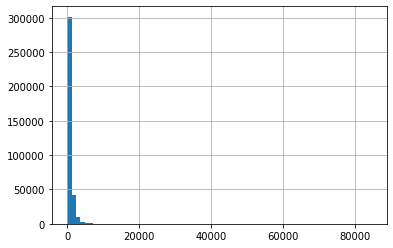

In [17]:
visits['duration_sec'].hist(bins=70)

Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю или медиану. Наше — не из таких, рассчитаем моду (значение в выборке, которое встречается чаще всего):

In [18]:
print('Значение моды (чаще всего) продолжительности визита равно {:} секунд'.format(visits['duration_sec'].mode().tolist()[0]))

Значение моды (чаще всего) продолжительности визита равно 60 секунд


<a name="2.1.4"></a><br/>
<font size="4"><b> 2.1.4 Как часто люди возвращаются?</b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

Чтобы ответить на этот вопрос нам необходимо разбить период времени на кагорты.
Когорта — группа людей, объединённых одним и тем же событием, произошедшим в определённый период времени.  
Выделить когорту просто. Надо определить:

1) событие, которое должно произойти с пользователем (для нас это первый вход на сайт Яндекс.Афиша) 

2) период, за который должно случиться событие(месяц например)


In [19]:
first_visit_of_user=pd.DataFrame(visits.groupby('uid')['start_ts'].min())
first_visit_of_user=first_visit_of_user.rename(columns={'start_ts': 'first_visit_of_user'})
first_visit_of_user.head(1)

,first_visit_of_user
uid,
11863502262781,2018-03-01 17:27:00


 Эту информацию добавим к информации о заказах.

In [20]:
visits=visits.merge(first_visit_of_user, on='uid',how='left')
visits.head(1)

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration_sec,first_visit_of_user
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,51,2017-12-20,1080,2017-12-20 17:20:00


Чтобы посчитать недельное и месячное использование, выделим в отдельный столбец месяц каждого посещения.

In [21]:
visits['1st_month_visit_of_user']= visits['first_visit_of_user'].astype('datetime64[M]')

In [22]:
#создаемстолбец воронки продолжительнось жизни кагорты, делаем преобразвания
visits['cohort_lifetime']=visits['month']-visits['1st_month_visit_of_user']
visits['cohort_lifetime']=visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime']=visits['cohort_lifetime'].round().astype(int)
visits.head(1)

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration_sec,first_visit_of_user,1st_month_visit_of_user,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,51,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,0


In [23]:
pivot_visits=visits.pivot_table(index='1st_month_visit_of_user', columns='cohort_lifetime',values='uid',aggfunc='nunique')
pivot_visits

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
1st_month_visit_of_user,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0,NaN
2017-08-01,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0,NaN,NaN
2017-09-01,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0,NaN,NaN,NaN
2017-10-01,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0,NaN,NaN,NaN,NaN
2017-11-01,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,25268.0,1410.0,960.0,786.0,512.0,481.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,22624.0,1351.0,890.0,565.0,458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,22197.0,1267.0,565.0,446.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# сделаем функцию построение хитмапа 
def make_heatmap(name_of_heatmap,table,fmt,vmax,cmap):
    plt.figure(figsize=(13, 9))
    plt.title(name_of_heatmap)
    ax=sns.heatmap(table, annot=True, fmt=fmt, linewidths=1, linecolor='gray', vmax=vmax, cmap=cmap)
    ax.set_yticklabels(table.index.date)
    ax.set_xticklabels(table.columns)
    print('')

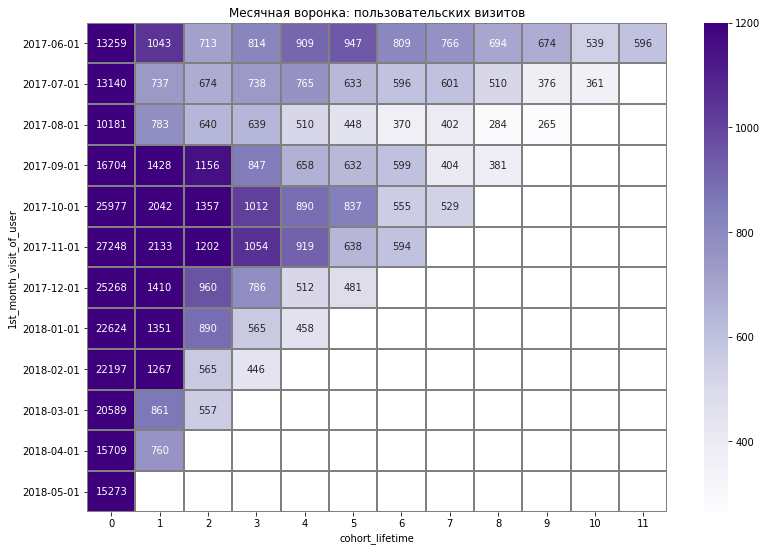

In [25]:
make_heatmap('Месячная воронка: пользовательских визитов',pivot_visits,'g',1200,'Purples')

##### Анализируя хитмап можно сказать следующие:
1. Максимальное число пользователей 27248 пришло 2017-11, наименьшее 10181 - в августе 2017.
2. Заметна общая тенденция по максимальному количеству возвращений пользователей на следующий месяц, после месяца прихода на сайт. 

-- максимальный показатель по возврату пользователей в кагорте 2017-11 это 2133 пользователей, минимальный 737 в кагорте 2017-07.

-- также заметна положительная корреляция количеста возврата пользователей, от количества пришедших пользователей, чем больше пришло, тем больше осталось.

3. Отчетливо видна динамика снижения количества возврата пользователей от месяца к месяцу почти в каждой кагорте.

-- так например, в кагорте 2018-01 количество пользователей снижалось по месяцам: в 1й- 1351, 2й -890, 3й -565, 4й - 459.

Расситаем показатели Retention Rate (англ. «коэффициент удержания») и Churn Rate (англ. «коэффициент оттока»).
Retention Rate показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды.

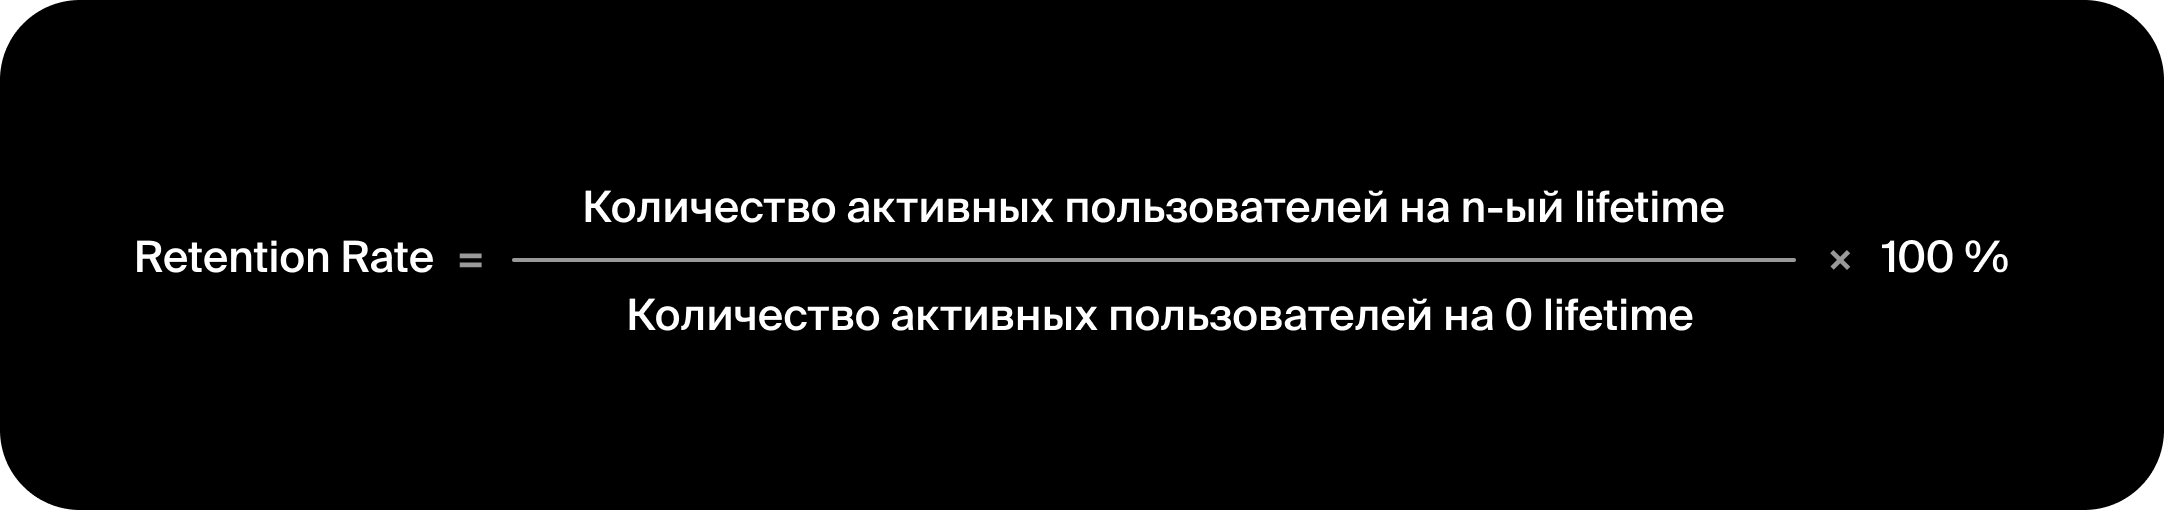

In [26]:
pivot_visits_rt = copy.deepcopy(pivot_visits)
pivot_visits_rt

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
1st_month_visit_of_user,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0,NaN
2017-08-01,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0,NaN,NaN
2017-09-01,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0,NaN,NaN,NaN
2017-10-01,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0,NaN,NaN,NaN,NaN
2017-11-01,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,25268.0,1410.0,960.0,786.0,512.0,481.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,22624.0,1351.0,890.0,565.0,458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,22197.0,1267.0,565.0,446.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
for index in pivot_visits_rt.index.tolist():
    index = str(index)[0:10]
    number=pivot_visits_rt.loc[index, 0]
    for col in pivot_visits_rt.columns.tolist():
        col = str(col)[0:10]
        if pivot_visits_rt.loc[index, int(col)]>0:
            pivot_visits_rt.loc[index, int(col)]=(pivot_visits_rt.loc[index, int(col)]/number)          

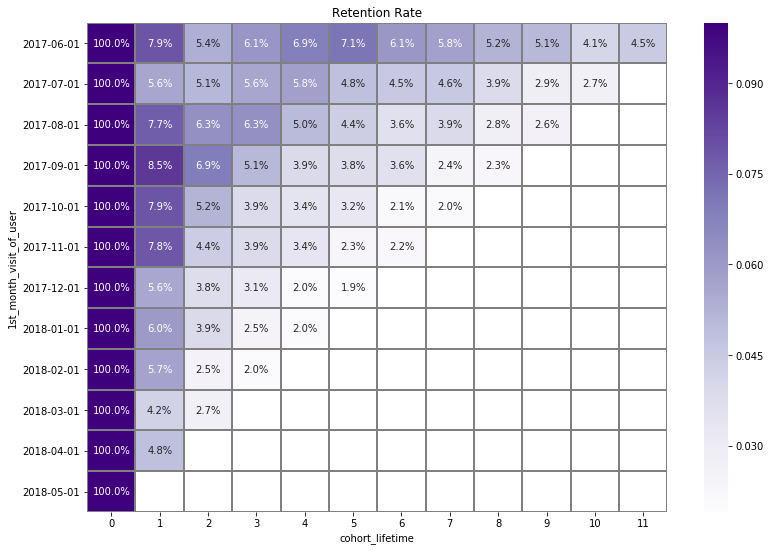

In [28]:
make_heatmap('Retention Rate',pivot_visits_rt,'.1%',0.1,'Purples')

Наибольший показатель удержания на первом месяце по всем кагортам, затем это показатель снижается,от месяца к месяцу.
Почему мы не можем удержать посетителей?! 

Churn Rate (англ. «коэффициент оттока»)показатель, позволяющий следить за здоровьем продукта. Он даёт понимание, какой процент пользователей прекращает использование продукта с течением времени. 

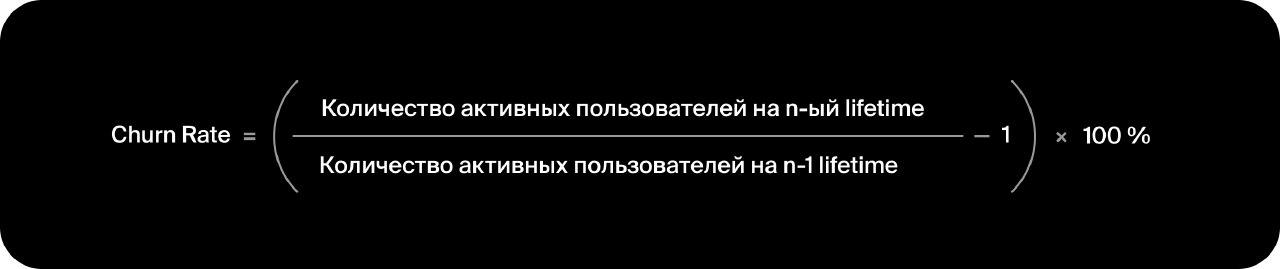
Чтобы рассчитать этот показатель, вызовем метод pct_change() (от англ. percentage change, «процентное изменение»). Он позволяет вычислить процентное изменение значения в столбце относительно предыдущей строки датафрейма. Если применить его с группировкой, метод сработает внутри группы.

In [29]:
cohorts = visits.groupby(['1st_month_visit_of_user','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [30]:
cohorts['churn_rate'] = cohorts.groupby(['1st_month_visit_of_user'])['uid'].pct_change()
churn_pivot = cohorts.pivot_table(index='1st_month_visit_of_user',columns='cohort_lifetime',values='churn_rate',aggfunc='sum')

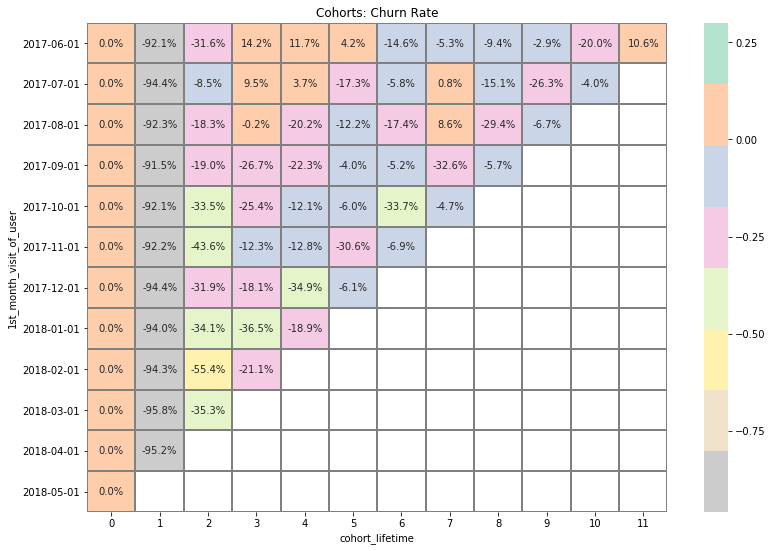

In [31]:
make_heatmap('Cohorts: Churn Rate',churn_pivot,'.1%',0.3,"Pastel2_r")

Анализируя таблицу видно, что наибольший показатель оттока на следующий месяц после прихода пользователей.
Затем он снижается, что не меняет общей тенденции оттока пользователей смотря на общую картину.
На общем фоне видно аномалию возвращения клиентов на 3 месяце по кагорте 2017-06 и 2017-07, к таким анамалиям нам и нужно стремиться! 
Надо проверить, что было предложено клиентам данных кагорт и повторить это для всех. Возможно там были бонусы.

<a name="2.2"></a><br/>
<a name="2.2.1"></a><br/>
<font size="4"><b> 2.2.1 Когда люди начинают покупать? </b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

Cначала просчитаем по каждому юзеру первый вход.

In [32]:
first_visit_of_user=pd.DataFrame(visits.groupby('uid')['start_ts'].min())
first_visit_of_user=first_visit_of_user.rename(columns={'start_ts': 'first_visit_of_user'})
first_visit_of_user.head(1)

,first_visit_of_user
uid,
11863502262781,2018-03-01 17:27:00


 Эту информацию добавим к информации о заказах.

In [33]:
len(first_visit_of_user)

228169

In [34]:
orders=orders.merge(first_visit_of_user, on='uid',how='left')
orders.head(1)

,buy_ts,revenue,uid,first_visit_of_user
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01 00:09:00


Затем посчитаем разницу в секундах, запишем в столбец 'time_for_buying_from_first_visit'

In [35]:
orders['time_for_buying_from_first_visit']=(orders['buy_ts']-orders['first_visit_of_user']).dt.seconds
orders.head(1)

,buy_ts,revenue,uid,first_visit_of_user,time_for_buying_from_first_visit
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01 00:09:00,60


In [36]:
values_of_time_for_buy=orders.groupby('uid')['time_for_buying_from_first_visit'].min().describe()
print('Среднее значение времени от первого визита до покупки равно {:.1f}'.format(values_of_time_for_buy.tolist()[1]),'секунд или {:.1f} часов'.format((values_of_time_for_buy.tolist()[1])/3600))
print('Значение медианы времени от первого визита до покупки равно {:.1f}'.format(values_of_time_for_buy.tolist()[-3]),'секунд или {:.1f} минут'.format((values_of_time_for_buy.tolist()[-3])/60))
print('Но чаще всего проходит {:.1f} секунд от первого визита до покупки'.format(orders.groupby('uid')['time_for_buying_from_first_visit'].min().mode().tolist()[0]))

Среднее значение времени от первого визита до покупки равно 13801.2 секунд или 3.8 часов
Значение медианы времени от первого визита до покупки равно 900.0 секунд или 15.0 минут
Но чаще всего проходит 60.0 секунд от первого визита до покупки


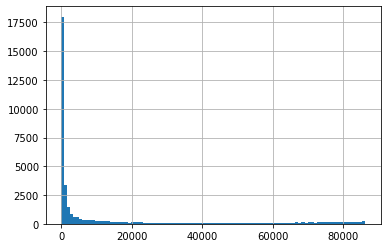

In [37]:
values_of_time_for_buy=orders.groupby('uid')['time_for_buying_from_first_visit'].min().hist(bins=100)

<a name="2.2.2"></a><br/>
<font size="4"><b>2.2.2 На каком по счету визите люди начинают покупать?</b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

#### Чтобы ответить на этот вопрос нужно:
1) Сначала выкинуть весь мусор  из visits и orders. Мусор - это заказы, которые не матчатся с визитом. Подробный пример ниже:

In [38]:
print('Клиент uid=313578113262317 совершил заказ-',orders.query('uid==313578113262317')['buy_ts'].tolist())

Клиент uid=313578113262317 совершил заказ- [Timestamp('2018-01-03 21:51:00')]


In [39]:
print('Все визиты клиента uid=313578113262317 из таблицы visits')
visits.query('uid==313578113262317')[['start_ts','end_ts']]

Все визиты клиента uid=313578113262317 из таблицы visits


,start_ts,end_ts
113873,2018-03-11 17:23:00,2018-03-11 17:29:00
173142,2017-09-18 22:49:00,2017-09-18 23:07:00
192554,2018-02-18 15:17:00,2018-02-18 15:26:00


##### Т.е. согласно таблице orders заказ от клиента uid=313578113262317 был совершен в январе 2018. Но в таблице visits нет подходящей сессии для этого заказа, т.к. сессии у клиента uid=313578113262317 за 2018 были только в феврале и марте!
#### Такие строки в orders и visits - это мусор.

2)В orders добавим столбец "номер заказа",затем сделаем цикл - счетчик заказов, какой заказ идет от клиента по счету, и причем он должен соответствовать хронологии.

3)Фильтруем orders по первому,  находим в visits нужную сессию, добавляем в колонку visits['first_order'] значение True

4)В visits добавляем столбец "номер визита", затем цикл-счетчик визитов в visits, опять же не забываем про хронологию

5)Фильтруем visits['first_order']по True, находим моду столбца "номер визита".

В итоге мы получили номер визита, по которому чаще всего сделан заказ, профит=)


In [40]:
#выберем из таблицы visits, только те строки с юзерами, которые покупали из таблицы orders, запишем срез в actual_visits
actual_visits=visits[visits['uid'].isin(orders['uid'])==True]

In [41]:
# создаем столбец epic_fail
orders['epic_fail']=0

Беру поочередно uid из orders, заглядываю в actual_visits через фильтр по первому uid из orders, смотрю даты визитов клиента. Если в визит, есть строки в которой дата заказа соответсвует условию:
actual_visits[start_ts]<order[buy_ts]<=actual_visits[end_ts]*, то
- столбец epic_fail=False.
- если нет таких строк - столбец epic_fail=True.
*сессия в которой была совершена покупка, не может быть нулевой по продолжительности времени, поэтому order[buy_ts] должно быть строго > actual_visits[start_ts]

In [42]:
start = time.time()
# проверка находится ли дата заказа между первой и последней сессией
# перебираем все строки из orders, берем поочередно uid и buy_ts, записываем 
for i in range(len(orders)):
    uid=orders['uid'][i]
    buy_ts=orders['buy_ts'][i]
               # делаем срез из таблицы актуальных визитов, и сохраняем номера строк в список
               # где выполняется условие actual_visits[uid]==orders[uid] &  actual_visits[start_ts]<order[buy_ts]<=actual_visits[end_ts]
    index_list=actual_visits.query('uid==@uid & end_ts>=@buy_ts & start_ts<@buy_ts').index.tolist()
    # если список с индексами строк не пустой, значит действительно, все ОК!
    # есть в таблице actual_visits строки удовлетворяющие условию подходящей сессии,
    # меняем столбец orders['epic_fail']=False
    if len(index_list)>0:
        orders['epic_fail'][i]='False'
    # если список с индексами пуст, строк таких нет epic_fail=True =)
    else:
        orders['epic_fail'][i]='True'

print('Количество "мусорных" заказов {:.1%}'.format(len(orders[orders['epic_fail']=='True'])/len(orders)))
end = time.time() 
print('Время работы цикла {:.1f}'.format((end-start)/60),'минут')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Количество "мусорных" заказов 36.4%
Время работы цикла 7.2 минут


В orders добавим столбец "номер заказа",затем сделаем цикл - счетчик заказов, какой заказ идет от клиента по счету, и причем он должен соответствовать хронологии.

In [43]:
print('В исходной таблице orders было всего заказов:',len(orders))
true_orders=orders[orders['epic_fail']=='False'].reset_index()
print('После актулизации заказов и сессий, заказов осталось:',len(true_orders))
actual_visits_true_orders=actual_visits[actual_visits['uid'].isin(true_orders['uid']) == True].reset_index()
print('Количество визитов по оставшимся пользователям из таблицы true orders равно:',len(actual_visits_true_orders))

В исходной таблице orders было всего заказов: 50415
После актулизации заказов и сессий, заказов осталось: 32042
Количество визитов по оставшимся пользователям из таблицы true orders равно: 74556


In [44]:
#сортируем по хронологии заказов
true_orders=true_orders.sort_values('buy_ts',ascending = True).reset_index()

true_orders.head(1)

,level_0,index,buy_ts,revenue,uid,first_visit_of_user,time_for_buying_from_first_visit,epic_fail
0,0,0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01 00:09:00,60,False


In [45]:
del true_orders['index']
del true_orders['level_0']

In [46]:
#добавляем столбец 'number_of_order'
true_orders['number_of_order']=0
true_orders.head(1)

,buy_ts,revenue,uid,first_visit_of_user,time_for_buying_from_first_visit,epic_fail,number_of_order
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01 00:09:00,60,False,0


In [47]:
# подсчет количества заказов
start = time.time()
for i in range(len(true_orders)):
    uid=true_orders['uid'][i]
    index_list=true_orders.query('uid==@uid & number_of_order==0').index.tolist()
    if len(index_list)==1:
        true_orders['number_of_order'][i]=1
    else:
        a=1
        for index in index_list:
            true_orders.loc[index,'number_of_order']=a
            a+=1            
end = time.time() 
print('Время работы цикла {:.1f}'.format((end-start)/60),'минут') 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Время работы цикла 2.3 минут


In [48]:
#тестовая проверка как цикл подсчитал номера заказов
true_orders.query('uid==11920452646463905188')

,buy_ts,revenue,uid,first_visit_of_user,time_for_buying_from_first_visit,epic_fail,number_of_order
405,2017-06-06 11:53:00,7.33,11920452646463905188,2017-06-01 11:38:00,900,False,1
440,2017-06-06 15:36:00,4.89,11920452646463905188,2017-06-01 11:38:00,14280,False,2
1426,2017-06-24 15:03:00,1.22,11920452646463905188,2017-06-01 11:38:00,12300,False,3
2004,2017-07-07 10:29:00,3.67,11920452646463905188,2017-06-01 11:38:00,82260,False,4
3729,2017-08-14 15:31:00,1.22,11920452646463905188,2017-06-01 11:38:00,13980,False,5
...,...,...,...,...,...,...,...
27805,2018-04-08 17:50:00,8.55,11920452646463905188,2017-06-01 11:38:00,22320,False,98
27837,2018-04-09 11:26:00,2.75,11920452646463905188,2017-06-01 11:38:00,85680,False,99
28052,2018-04-12 20:47:00,3.05,11920452646463905188,2017-06-01 11:38:00,32940,False,100
29838,2018-05-09 17:10:00,1.53,11920452646463905188,2017-06-01 11:38:00,19920,False,101


##### Фильтруем orders по первому заказу,  находим в visits нужную сессию, добавляем в колонку visits['first_order'] значение True

In [49]:
# таблица заказов в которой только ПЕРВЫЕ заказы
true_of_1orders=true_orders.query('number_of_order==1').reset_index()
del true_of_1orders['index']
true_of_1orders

,buy_ts,revenue,uid,first_visit_of_user,time_for_buying_from_first_visit,epic_fail,number_of_order
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,60,False,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,660,False,1
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,120,False,1
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,900,False,1
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,1620,False,1
...,...,...,...,...,...,...,...
27193,2018-05-31 23:42:00,0.92,15854392578508828030,2018-05-31 23:26:00,960,False,1
27194,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,52740,False,1
27195,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,2700,False,1
27196,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,120,False,1


In [50]:
actual_visits_true_orders['first_order']=''
#проверка нумерации индексов перед запуском цикла
print(len(actual_visits_true_orders))
actual_visits_true_orders.tail(1)

74556


,index,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration_sec,first_visit_of_user,1st_month_visit_of_user,cohort_lifetime,first_order
74555,359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-01,2018-01-01,4,2018-01-25,19,2018-01-25 17:38:00,2018-01-01,0,


In [51]:
#добавляем в визиты пометку первого заказа в талицу actual_visits_true_orders
start = time.time() 
for i in range(len(true_of_1orders)):
    uid=true_of_1orders['uid'][i]
    buy_ts=true_of_1orders['buy_ts'][i]
    index_list=actual_visits_true_orders.query('uid==@uid & end_ts>=@buy_ts & start_ts<@buy_ts').index.tolist()
    if len(index_list)>1:
        for index in index_list:
            actual_visits_true_orders.loc[index,'first_order']='True'
            #ПРЕРЫВАЕМ ЦИКЛ КОГДА НАШЛИ ТРУШНО-ЗАКАЗНЫЙ ВИЗИТ
            break
    elif len(index_list)==1:
        actual_visits_true_orders.loc[index_list,'first_order']='True'
end = time.time() 
print('Время работы цикла {:.1f}'.format((end-start)/60),'минут')

Время работы цикла 4.3 минут


In [52]:
# Тестовая проверка как у нас визиты подсчитались
actual_visits_true_orders.query('uid==11920452646463905188')

,index,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration_sec,first_visit_of_user,1st_month_visit_of_user,cohort_lifetime,first_order
165,799,desktop,2017-10-19 12:06:00,1,2017-10-19 12:05:00,11920452646463905188,2017-01-01,2017-10-01,42,2017-10-19,60,2017-06-01 11:38:00,2017-06-01,4,
656,3247,desktop,2017-10-13 13:10:00,3,2017-10-13 13:02:00,11920452646463905188,2017-01-01,2017-10-01,41,2017-10-13,480,2017-06-01 11:38:00,2017-06-01,4,
894,4479,desktop,2017-11-22 12:06:00,2,2017-11-22 11:39:00,11920452646463905188,2017-01-01,2017-11-01,47,2017-11-22,1620,2017-06-01 11:38:00,2017-06-01,5,
910,4535,desktop,2017-12-14 12:32:00,1,2017-12-14 12:30:00,11920452646463905188,2017-01-01,2017-12-01,50,2017-12-14,120,2017-06-01 11:38:00,2017-06-01,6,
1087,5420,desktop,2017-09-27 14:23:00,5,2017-09-27 13:39:00,11920452646463905188,2017-01-01,2017-09-01,39,2017-09-27,2640,2017-06-01 11:38:00,2017-06-01,3,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72780,351938,desktop,2018-03-06 18:35:00,2,2018-03-06 18:34:00,11920452646463905188,2018-01-01,2018-03-01,10,2018-03-06,60,2017-06-01 11:38:00,2017-06-01,9,
73014,352970,desktop,2017-07-03 12:53:00,1,2017-07-03 12:49:00,11920452646463905188,2017-01-01,2017-07-01,27,2017-07-03,240,2017-06-01 11:38:00,2017-06-01,1,
73255,354103,desktop,2017-09-24 11:05:00,5,2017-09-24 10:59:00,11920452646463905188,2017-01-01,2017-09-01,38,2017-09-24,360,2017-06-01 11:38:00,2017-06-01,3,
73578,355664,desktop,2018-01-30 13:28:00,5,2018-01-30 13:27:00,11920452646463905188,2018-01-01,2018-01-01,5,2018-01-30,60,2017-06-01 11:38:00,2017-06-01,7,


4.В visits добавляем столбец "номер визита", затем цикл-счетчик визитов в visits, опять же не забываем про хронологию

In [53]:
actual_visits_true_orders['number_of_visit']=''
#сортируем по хронологии входов
actual_visits_true_orders=actual_visits_true_orders.sort_values('start_ts',ascending = True).reset_index()
del actual_visits_true_orders['level_0']
del actual_visits_true_orders['index']
print(len(actual_visits_true_orders))
actual_visits_true_orders.tail(1)

74556


,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration_sec,first_visit_of_user,1st_month_visit_of_user,cohort_lifetime,first_order,number_of_visit
74555,desktop,2018-06-01 00:04:00,4,2018-05-31 23:59:00,83872787173869366,2018-01-01,2018-05-01,22,2018-05-31,300,2018-05-31 23:59:00,2018-05-01,0,True,


In [54]:
#ЦИКЛ-СЧЕТЧИК ВИЗИТОВ
start = time.time()
list_uid = set()
for i in range(len(actual_visits_true_orders)):
    uid=actual_visits_true_orders['uid'][i]
    if uid in list_uid:
        continue
    index_list=actual_visits_true_orders.query('uid==@uid & uid not in @list_uid  & number_of_visit==""').index.tolist()
    list_uid.add(uid)
    if len(index_list)==1:
        actual_visits_true_orders['number_of_visit'][i]=1
        
    elif len(index_list)>1:    
        a=1
        for index in index_list:
            actual_visits_true_orders.loc[index,'number_of_visit']=a
            a+=1
            if actual_visits_true_orders.loc[index,'first_order']=='True':
                 #ПРЕРЫВАЕМ ЦИКЛ КОГДА НАШЛИ ТРУШНО-ЗАКАЗНЫЙ ВИЗИТ
                break       
end = time.time() 
print('Время работы цикла {:.1f}'.format((end-start)/60),'минут')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Время работы цикла 6.1 минут


In [55]:
# проверка
actual_visits_true_orders.query('uid==11920452646463905188')

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration_sec,first_visit_of_user,1st_month_visit_of_user,cohort_lifetime,first_order,number_of_visit
46,desktop,2017-06-01 11:38:00,1,2017-06-01 11:38:00,11920452646463905188,2017-01-01,2017-06-01,22,2017-06-01,0,2017-06-01 11:38:00,2017-06-01,0,,1
564,desktop,2017-06-05 12:13:00,5,2017-06-05 11:37:00,11920452646463905188,2017-01-01,2017-06-01,23,2017-06-05,2160,2017-06-01 11:38:00,2017-06-01,0,,2
812,desktop,2017-06-06 11:54:00,5,2017-06-06 11:23:00,11920452646463905188,2017-01-01,2017-06-01,23,2017-06-06,1860,2017-06-01 11:38:00,2017-06-01,0,True,3
880,desktop,2017-06-06 15:37:00,5,2017-06-06 15:29:00,11920452646463905188,2017-01-01,2017-06-01,23,2017-06-06,480,2017-06-01 11:38:00,2017-06-01,0,,
1815,desktop,2017-06-12 15:49:00,5,2017-06-12 15:48:00,11920452646463905188,2017-01-01,2017-06-01,24,2017-06-12,60,2017-06-01 11:38:00,2017-06-01,0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70084,desktop,2018-05-12 11:42:00,5,2018-05-12 11:35:00,11920452646463905188,2018-01-01,2018-05-01,19,2018-05-12,420,2017-06-01 11:38:00,2017-06-01,11,,
70103,desktop,2018-05-12 13:17:00,5,2018-05-12 13:15:00,11920452646463905188,2018-01-01,2018-05-01,19,2018-05-12,120,2017-06-01 11:38:00,2017-06-01,11,,
73661,desktop,2018-05-30 09:03:00,3,2018-05-30 08:48:00,11920452646463905188,2018-01-01,2018-05-01,22,2018-05-30,900,2017-06-01 11:38:00,2017-06-01,11,,
73666,desktop,2018-05-30 09:31:00,5,2018-05-30 09:05:00,11920452646463905188,2018-01-01,2018-05-01,22,2018-05-30,1560,2017-06-01 11:38:00,2017-06-01,11,,


In [56]:
note=actual_visits_true_orders.query('first_order=="True"')['number_of_visit'].describe().tolist()
print('Покупатели совершают свою первую покупку на визите №',actual_visits_true_orders.query('first_order=="True"')['number_of_visit'].mode().tolist()[0])
print('{:.1%} всех заказов были совершены на визите №'.format(note[3]/note[0]),note[2])
print('Cамый поздний первый заказ был совершен на визите №'.format(note[3]/note[0]),note[1])

Покупатели совершают свою первую покупку на визите № 1
68.9% всех заказов были совершены на визите № 1
Cамый поздний первый заказ был совершен на визите № 48


### ВАЖНО!
### Без выкидывания мусора не ответить на вопрос на какой сессии покупают, НО в дальнейшей работе я использовал все заказы из таблицы orders. Если выкину 34% заказов,то вывод можно сразу написать:"Маркетологов уволить, бизнес закрыть"

### Предполагаю, наличие мусора связано:
1. когда нам давали дата фреймы, неудачно зарандомили даты, поэтому так вышло.
2. или проблемы выгрузки.
##### в любом случае, озвучил бы эту проблему разработчикам при получении таких датафреймов.

<a name="2.2.3"></a><br/>
<font size="4"><b> 2.2.3 Сколько раз покупают за период?</b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

In [57]:
orders['order_year'] = orders['buy_ts'].astype('datetime64[Y]')
orders['order_month']= orders['buy_ts'].astype('datetime64[M]')
orders['order_week_week'] = orders['buy_ts'].dt.week
orders['order_date'] = orders['buy_ts'].astype('datetime64[D]')

In [58]:
dict_of_period={'order_month': 'месяц', 'order_week_week': 'неделю', 'order_date':'день'}
def print_count_of_buy_for_period(period):
    print('Среднее количество покупок в',dict_of_period[period],':', int(orders.groupby(period)['revenue'].count().describe().tolist()[1]))
    print('Значение медианы количество покупок в',dict_of_period[period],':', int(orders.groupby(period)['revenue'].count().describe()[-3]),'\n')

In [59]:
for name in dict_of_period.keys():
    print_count_of_buy_for_period(name)

Среднее количество покупок в месяц : 3878
Значение медианы количество покупок в месяц : 4346 

Среднее количество покупок в неделю : 969
Значение медианы количество покупок в неделю : 997 

Среднее количество покупок в день : 138
Значение медианы количество покупок в день : 136 



In [60]:
#определем первый месяц заказа
first_order_date_by_customers = orders.groupby('uid')['buy_ts'].min()
first_order_date_by_customers.name = 'first_order_date'
# добавляем в таблицу orders
orders = orders.merge(first_order_date_by_customers,on='uid')

In [61]:
# добавляем в таблицу orders месяц первой покупки у клиента
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,first_visit_of_user,time_for_buying_from_first_visit,epic_fail,order_year,order_month,order_week_week,order_date,first_order_date,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,60,False,2017-01-01,2017-06-01,22,2017-06-01,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,660,False,2017-01-01,2017-06-01,22,2017-06-01,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,120,False,2017-01-01,2017-06-01,22,2017-06-01,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,900,False,2017-01-01,2017-06-01,22,2017-06-01,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,1620,False,2017-01-01,2017-06-01,22,2017-06-01,2017-06-01 07:58:00,2017-06-01


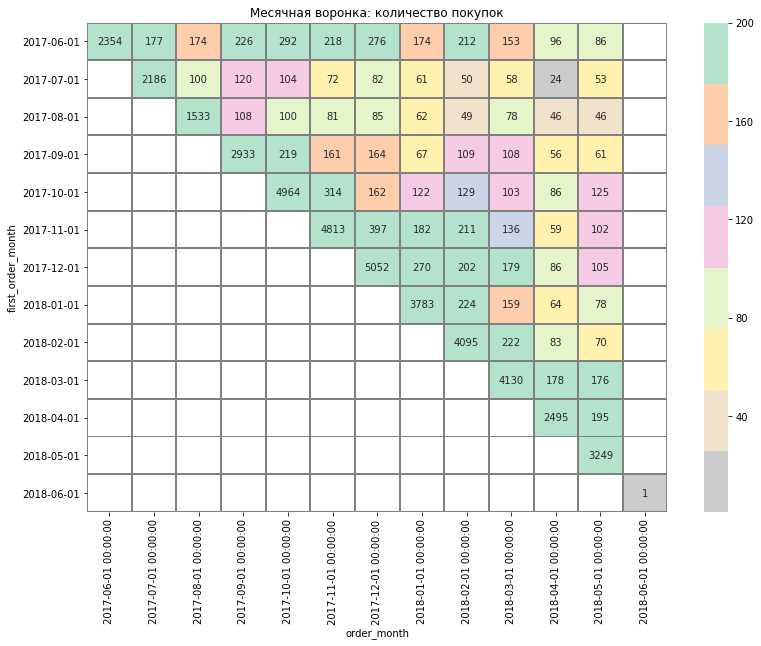

In [62]:
'''формируем сводную таблицу, где индексом будет первый месяц у клиента, который сделал заказ
в качестве значений будем выводить количество заказов сделаные с разбивкой по месяцам '''
orders_pivot_count_of_orders=orders.pivot_table(index='first_order_month',columns='order_month',values='buy_ts',aggfunc='count')
make_heatmap('Месячная воронка: количество покупок',orders_pivot_count_of_orders,'g',200,"Pastel2_r")

#### Проанализировав таблицу делаем следующие выводы:
* наибольшее количество 5052 заказа от новых клиентов мы получили в декабре
* 1533 наименьший показатель по количеству заказов от новых клиентов за август месяц (разгар сезона отпусков)
* наибольшее число повторных заказов в месяц, совершила кагорта клиентов пришедшая в ноябре 
##### Однозначно, что в декабре наибольшее количество заказов связано с предстоящими праздниками, билеты могут покупатся в подарок.
##### Также, это могло и повлиять на наибольший показатель повторных заказов ноябрьской кагорты клиентов.
* Если отбросить декабрьские продажи, то отчетливо видно, что клиенты которые только пришли, в большинстве случаев(одно исключение было в июле всего 100 заказов) сделают наибольшое количество повторных заказов сразу в следующем месяце, чем когда-либо 
##### за 2018-06-01 был один заказ, надо удалить эту строку,чтобы не портил статистику. Очевидно, что выгрузка была за год и этот заказ лишний.

//Если бы была возможность посмотреть на даты самих мероприятий на которые покупают клиенты в конкретном месяце, выводы могли бы быть интереснее.

In [63]:
# посмотрим на те же показатели, только через воронку времени
orders['cohort_lifetime']=orders['order_month']-orders['first_order_month']
orders['cohort_lifetime']=orders['cohort_lifetime'] / np.timedelta64(1,'M')
orders['cohort_lifetime']=orders['cohort_lifetime'].round().astype(int)
orders.head(1)

,buy_ts,revenue,uid,first_visit_of_user,time_for_buying_from_first_visit,epic_fail,order_year,order_month,order_week_week,order_date,first_order_date,first_order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01 00:09:00,60,False,2017-01-01,2017-06-01,22,2017-06-01,2017-06-01 00:10:00,2017-06-01,0


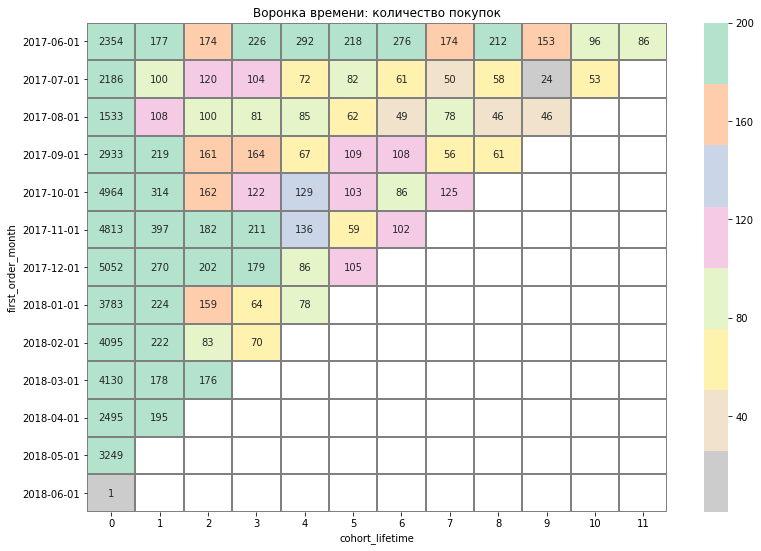

In [64]:
cohort_orders_pivot_count_of_orders=orders.pivot_table(index='first_order_month',columns='cohort_lifetime',values='buy_ts',aggfunc='count')
make_heatmap('Воронка времени: количество покупок',cohort_orders_pivot_count_of_orders,'g',200,"Pastel2_r")

In [65]:
# удалили лишний заказ, он был последний в таблице, поэтому переиндексация нам не нужна
orders.drop(orders.query('first_order_month=="2018-06-01"').index, inplace=True)

<a name="2.2.4"></a><br/>
<font size="4"><b> 2.2.4 Какой средний чек?</b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

Для начала определим понятие среднего чека.
Средний чек - это размер выручки деленный на количество заказов за определенный период.

In [66]:
# т.к. в таблице orders одна строка фактически является одним заказом, то средний чек мы можем расчитать следующим образом
print('Средний чек равен {:.2f}'.format(orders['revenue'].mean()),'у.е.')
print('Медианное значение суммы чека равно {:.2f}'.format(orders['revenue'].median()),'у.е.')

Средний чек равен 5.00 у.е.
Медианное значение суммы чека равно 2.50 у.е.


Надо посмотреть, как и когда менялся размер чека с периодом времени.
Снова сделаем кагортный анализ.

In [67]:
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','buy_ts':'count'})
orders_grouped_by_cohorts.rename(columns={'buy_ts': 'count_of_orders'}, inplace=True)
orders_grouped_by_cohorts.head()

revenue  count_of_orders
first_order_month order_month                          
2017-06-01        2017-06-01   9557.49             2354
                  2017-07-01    981.82              177
                  2017-08-01    885.34              174
                  2017-09-01   1931.30              226
                  2017-10-01   2068.58              292

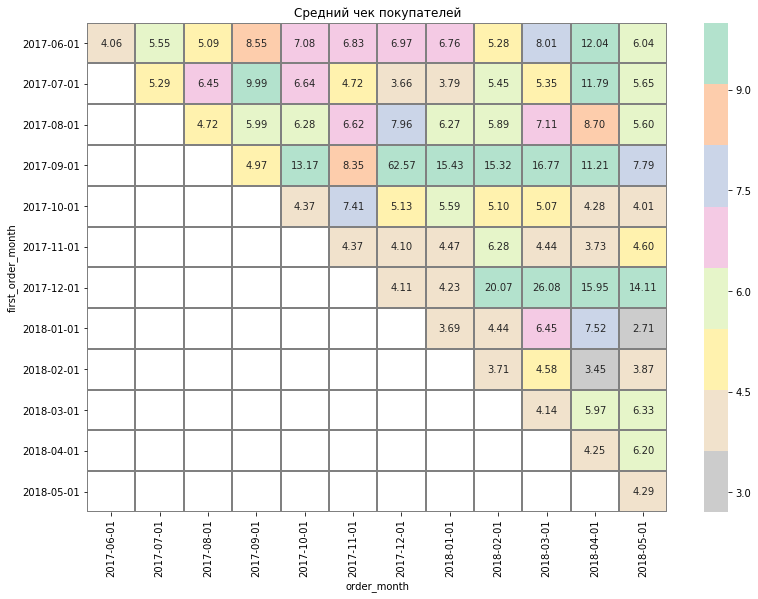

In [68]:
orders_grouped_by_cohorts['revenue_per_order'] = (orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['count_of_orders']).round(2)
orders_pivot_count_of_orders=orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='order_month',values='revenue_per_order',aggfunc='mean')
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
ax=sns.heatmap(orders_pivot_count_of_orders, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmax=10,cmap="Pastel2_r")
ax.set_yticklabels(orders_pivot_count_of_orders.index.date)
ax.set_xticklabels(orders_pivot_count_of_orders.columns.date)
print('')

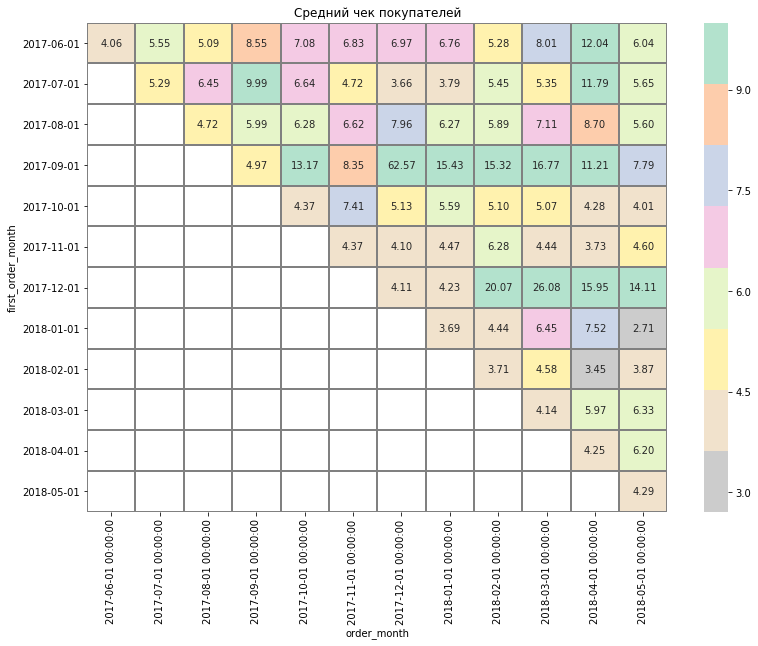

In [69]:
make_heatmap('Средний чек покупателей',orders_pivot_count_of_orders,'.2f',10,"Pastel2_r")

Найдём lifetime когорты. Из месяца совершения заказа order_month вычтем месяц когорты first_order_month:



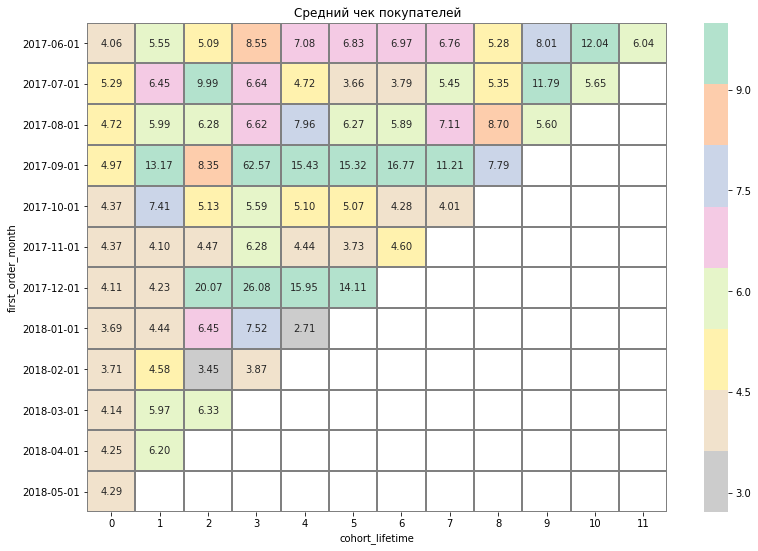

In [70]:
cohort_lifetime_orders=orders.pivot_table(index='first_order_month',columns='cohort_lifetime',values='revenue',aggfunc='mean')
make_heatmap('Средний чек покупателей',cohort_lifetime_orders,'.2f',10,"Pastel2_r")

У когорты 2017-12 и 2017-09 аномально большие средние чеки, максимум был 62.57, интересно, что на это повлияло..

<a name="2.2.5"></a><br/>
<font size="4"><b> 2.2.5 Сколько денег приносят? (LTV)</b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

LTV (от англ. lifetime value) — «пожизненная» ценность клиента. Это — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок. При расчёте LTV обычно обращаются к валовой прибыли с клиента за период.

групирую по клиентам и считаю сколько выручки принес.

In [71]:
'''
# валовая выручка с клиента за год в среднем
ltv=orders.groupby('uid').agg({'revenue':'sum'}).mean()
print('Валовая выручка с клиента за год в среднем:',ltv[0].round(2))
'''

"\n# валовая выручка с клиента за год в среднем\nltv=orders.groupby('uid').agg({'revenue':'sum'}).mean()\nprint('Валовая выручка с клиента за год в среднем:',ltv[0].round(2))\n"

<a name="2.3"></a><br/>
### 2.3 Маркетинг
<a name="2.3.1"></a><br/>
<font size="4"><b> 2.3.1 Сколько денег потратили? Всего / на каждый источник / по времени</b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

Найденем клиентов, которые прожили от 6 месяцев,а также возьмем период жизни за 6 месяцев

In [72]:
# список uid кто прожил 6 месяцев, запишем в uid_who_lived_6months
uid_who_lived_6months=orders.query('cohort_lifetime<7 & first_order_month<="2017-11-01T00:00:00.000000000"')['uid'].unique().tolist()
#оставим в таблице orders только, тех кто прожил 6 месяцев минимум и период жизни 6 месяцев
mean_revenue_for_6months=orders.query('cohort_lifetime<=6 & uid==@uid_who_lived_6months').groupby('uid').agg({'revenue':'sum'}).mean()
print('Валовая выручка с клиента за полгода в среднем:',mean_revenue_for_6months[0].round(2)) 

Валовая выручка с клиента за полгода в среднем: 8.03


Посмотрим на разброс значений.

In [73]:
orders.query('cohort_lifetime<=6 & uid==@uid_who_lived_6months').groupby('uid').agg({'revenue':'sum'}).describe()

,revenue
count,16318.000000
mean,8.025903
std,97.575518
min,0.000000
25%,1.470000
50%,3.050000
75%,6.110000
max,11704.770000


Глядя на распределение выручки(среднее почти в 3 раза больше медианы), очевидно, что среднее тут совсем не показатель.

Проведем детальный анализ

In [74]:
orders['buy_ts'].describe()

count                   50414
unique                  45990
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-05-31 23:56:00
Name: buy_ts, dtype: object

In [75]:
print(costs.head())
costs['date'].describe()

   source_id       date  costs
0          1 2017-06-01  75.20
1          1 2017-06-02  62.25
2          1 2017-06-03  36.53
3          1 2017-06-04  55.00
4          1 2017-06-05  57.08


count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: date, dtype: object

Диапазон дат расходов совпадает с датами заказов.
LTV удобно считать по когортам. Вспомним, что для этого нужно:
найти дату первой покупки каждого покупателя;
вычислить число новых покупателей за каждую дату;
добавить дату первой покупки в таблицу с заказами;
сгруппировать таблицу и посчитать выручку.

In [76]:
costs

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [77]:
costs['month'] = costs['date'].astype('datetime64[M]')

In [78]:
orders.head(1)

,buy_ts,revenue,uid,first_visit_of_user,time_for_buying_from_first_visit,epic_fail,order_year,order_month,order_week_week,order_date,first_order_date,first_order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01 00:09:00,60,False,2017-01-01,2017-06-01,22,2017-06-01,2017-06-01 00:10:00,2017-06-01,0


In [79]:
# Получим месяц первой покупки каждого покупателя:
first_orders_month_by_customers = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders_month_by_customers.columns = ['uid', 'first_order_month']
first_orders_month_by_customers.tail(1)

,uid,first_order_month
36521,18446167067214817906,2017-10-01


In [80]:
# воронка, первый месяц покупки, кол-во покупателей
cohort_sizes =first_orders_month_by_customers.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [81]:
orders=orders.merge(cohort_sizes, on='first_order_month')
orders.head(1)

,buy_ts,revenue,uid,first_visit_of_user,time_for_buying_from_first_visit,epic_fail,order_year,order_month,order_week_week,order_date,first_order_date,first_order_month,cohort_lifetime,n_buyers
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01 00:09:00,60,False,2017-01-01,2017-06-01,22,2017-06-01,2017-06-01 00:10:00,2017-06-01,0,2023


In [82]:
report=orders.groupby(['first_order_month','n_buyers','order_month'])['revenue'].sum().reset_index()
report.tail(1)

,first_order_month,n_buyers,order_month,revenue
77,2018-05-01,2988,2018-05-01,13925.76


In [83]:
# gross_profit
# возьмем margin_rate 50%
margin_rate = 0.5
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report

,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,4778.745,0
1,2017-06-01,2023,2017-07-01,981.82,490.910,1
2,2017-06-01,2023,2017-08-01,885.34,442.670,2
3,2017-06-01,2023,2017-09-01,1931.30,965.650,3
4,2017-06-01,2023,2017-10-01,2068.58,1034.290,4
...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,531.525,1
74,2018-03-01,3533,2018-05-01,1114.87,557.435,2
75,2018-04-01,2276,2018-04-01,10600.69,5300.345,0
76,2018-04-01,2276,2018-05-01,1209.92,604.960,1


In [84]:
report.head(10)

,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,4778.745,0
1,2017-06-01,2023,2017-07-01,981.82,490.910,1
2,2017-06-01,2023,2017-08-01,885.34,442.670,2
3,2017-06-01,2023,2017-09-01,1931.30,965.650,3
4,2017-06-01,2023,2017-10-01,2068.58,1034.290,4
5,2017-06-01,2023,2017-11-01,1487.92,743.960,5
6,2017-06-01,2023,2017-12-01,1922.74,961.370,6
7,2017-06-01,2023,2018-01-01,1176.56,588.280,7
8,2017-06-01,2023,2018-02-01,1119.15,559.575,8
9,2017-06-01,2023,2018-03-01,1225.51,612.755,9


In [85]:
report['ltv'] = report['gp'] / report['n_buyers']
    
ltv_report = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)

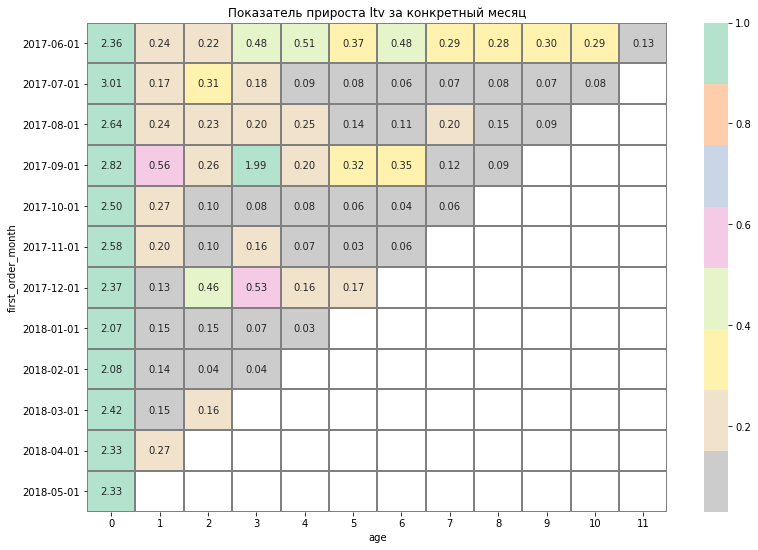

In [86]:
make_heatmap('Показатель прироста ltv за конкретный месяц',ltv_report,'.2f',1,"Pastel2_r")

ltv подсчитан.

### <font color='blue'>тут ниже подсчитан кумулятивный показатель ltv</font> 

In [87]:
ltv=ltv_report.cumsum(axis=1).round(2)

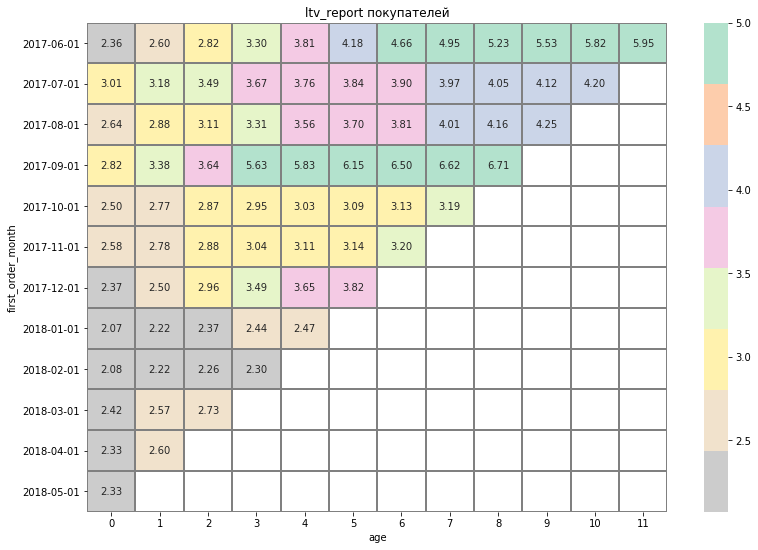

In [88]:
make_heatmap('ltv_report покупателей',ltv,'.2f',5,"Pastel2_r")

In [89]:
# создадим словарь кагорта -ключ, лтв - значение
dict_ltv={}
report['age'].unique().tolist()
index_ltv=ltv.index.tolist()
age=sorted(report['age'].unique().tolist(),reverse=True)
for i in range(len(age)):
    dict_ltv[str(index_ltv[i])[:10]]=ltv.loc[index_ltv[i],age[i]]
dict_ltv_df=pd.Series(dict_ltv).reset_index()

Text(0, 0.5, 'LTV')

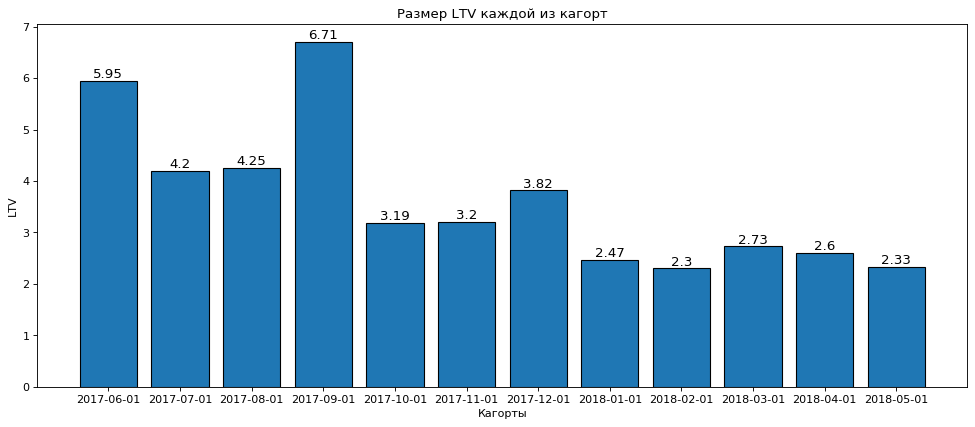

In [132]:
plt.figure(figsize=(15,6), dpi= 80)
plt.bar(dict_ltv_df['index'], dict_ltv_df[0],ec='black' ) 
for i, val in enumerate(dict_ltv_df[0].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.title('Размер LTV каждой из кагорт')
plt.gca().set_xticklabels(dict_ltv_df['index'],)
plt.xlabel('Кагорты')
plt.ylabel('LTV')

Логично было бы получить график, на котором отразилось бы гипотеза, что "чем старше кагорта, тем выше LTV".
По факту совсем не так. Кагорта 2017-09-01 по уровню LTV превосходит самую старшую кагорту.
Такое может быть потомучто количество пользователей из кагорт разное, где-то пришло больше/меньше.

<a name="2.3"></a><br/>
### 2.3 Маркетинг
<a name="2.3.1"></a><br/>
<font size="4"><b> 2.3.1 Сколько денег потратили? Всего / на каждый источник / по времени</b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

In [91]:
print('Общие затраты на маркетинг за весь период времени составили: {:.2f} у.е.'.format(costs['costs'].sum()))

Общие затраты на маркетинг за весь период времени составили: 329131.62 у.е.


In [92]:
costs_of_source=pd.DataFrame(costs.groupby('source_id')['costs'].sum().round(2)).reset_index()
costs_of_source['source_id']=costs_of_source['source_id'].astype(str)
costs_of_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [133]:
def make_graf(title,col1,col2,ylabel):
    plt.figure(figsize=(15,6), dpi= 80)
    plt.bar(col1, col2,ec='black' ) 
    for i, val in enumerate(col2.values):
        plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
    plt.title(title)
    plt.gca().set_xticklabels(col1)
    plt.xlabel('Источник')
    plt.ylabel(ylabel)

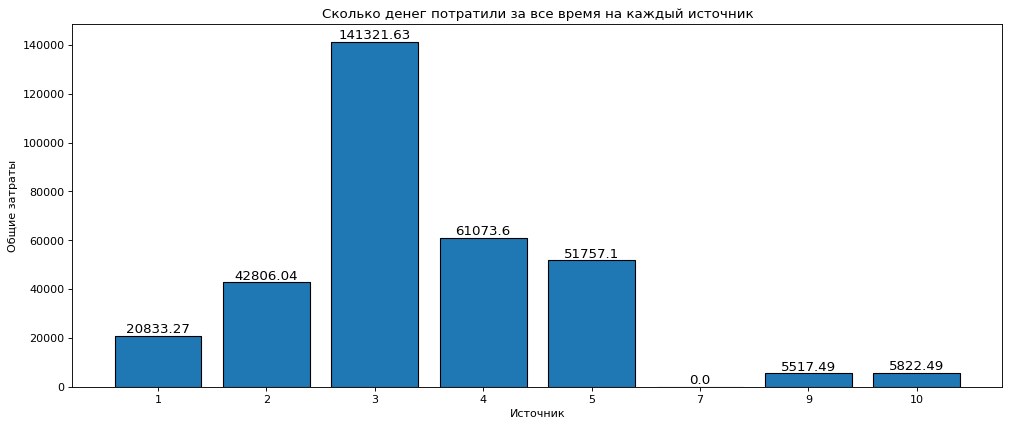

In [134]:
make_graf('Сколько денег потратили за все время на каждый источник',costs_of_source['source_id'],costs_of_source['costs'],"Общие затраты")

<a name="2.3.2"></a><br/>
<font size="4"><b> 2.3.2 Сколько стоило привлечение одного покупателя из каждого источника?</b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

In [95]:
orders_pivot=orders.pivot_table(index='uid',values='first_order_date',aggfunc='min')
actual_visits_pivot=actual_visits.pivot_table(index='uid',values='start_ts',aggfunc='min')
orders_pivot=orders_pivot.merge(actual_visits_pivot, on='uid')
orders_pivot['source_id']='X'
orders_pivot=orders_pivot.reset_index()

In [96]:
orders_pivot

,uid,first_order_date,start_ts,source_id
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,X
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,X
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,X
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,X
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,X
...,...,...,...,...
36517,18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00,X
36518,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,X
36519,18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00,X
36520,18446156210226471712,2018-02-18 19:34:00,2017-11-07 10:01:00,X


In [97]:
# заполним source_id таблицы orders_pivot
for i in range(len(orders_pivot)):
    uid=orders_pivot['uid'][i]
    start_ts=orders_pivot['start_ts'][i]
    index_source_id=actual_visits.query('uid==@uid & start_ts==@start_ts').index.tolist()
    if len(index_source_id)>1:
        print('Epic Fail',uid)
    else:
        orders_pivot['source_id'][i]=actual_visits.loc[index_source_id[0],'source_id']
orders_pivot.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,uid,first_order_date,start_ts,source_id
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,10
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,3
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,5
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,5


In [98]:
orders_pivot=orders_pivot.merge(orders.groupby('uid').agg({'revenue':'sum'}),on='uid')

In [99]:
orders_pivot

,uid,first_order_date,start_ts,source_id,revenue
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2,0.55
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,10,3.05
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,3,73.33
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,5,2.44
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,5,10.99
...,...,...,...,...,...
36517,18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00,5,3.05
36518,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,3,0.88
36519,18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00,2,4.22
36520,18446156210226471712,2018-02-18 19:34:00,2017-11-07 10:01:00,3,9.78


In [100]:
costs.head(1)

,source_id,date,costs,month
0,1,2017-06-01,75.2,2017-06-01


In [101]:
revenue_of_source=orders_pivot.groupby('source_id').agg({'revenue':'sum'}).reset_index()
revenue_of_source['source_id']=revenue_of_source['source_id'].astype('str')
orders_pivot_source_id=orders_pivot.groupby('source_id').agg({'uid':'count'}).reset_index()
orders_pivot_source_id['source_id']=orders_pivot_source_id['source_id'].astype(str)

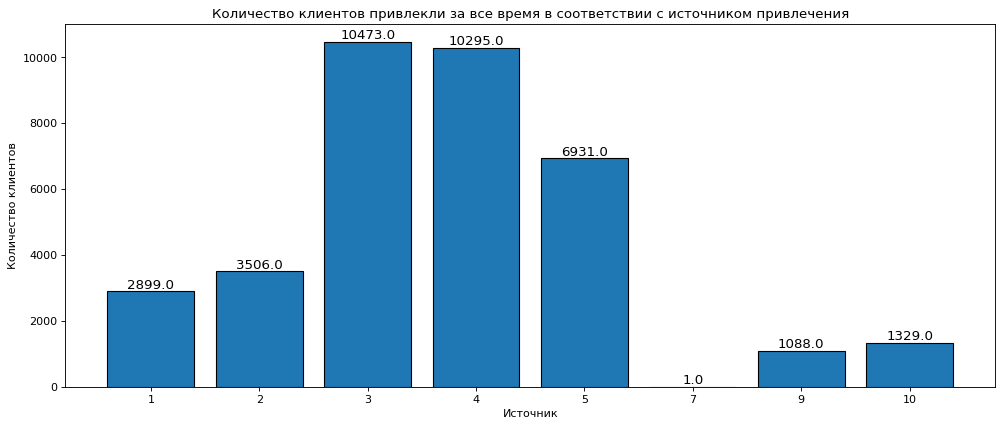

In [135]:
make_graf('Количество клиентов привлекли за все время в соответствии с источником привлечения',orders_pivot_source_id['source_id'],
          orders_pivot_source_id['uid'],"Количество клиентов")

In [103]:
count_of_buyers_by_source_id=pd.DataFrame(orders_pivot.groupby('source_id')['uid'].count()).reset_index()
count_of_buyers_by_source_id.rename(columns={'uid': 'count_of_uid'}, inplace=True)
count_of_buyers_by_source_id['source_id']=count_of_buyers_by_source_id['source_id'].astype(str)
count_of_buyers_by_source_id

,source_id,count_of_uid
0,1,2899
1,2,3506
2,3,10473
3,4,10295
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [104]:
costs_of_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [105]:
#соединим две таблицы
costs_of_source=count_of_buyers_by_source_id.merge(costs_of_source, on='source_id',how='left')
costs_revenue_of_source=costs_of_source.merge(revenue_of_source,on='source_id')
costs_revenue_of_source.fillna(0)

,source_id,count_of_uid,costs,revenue
0,1,2899,20833.27,31090.55
1,2,3506,42806.04,46923.61
2,3,10473,141321.63,54511.24
3,4,10295,61073.60,56693.41
4,5,6931,51757.10,52624.02
5,7,1,0.00,1.22
6,9,1088,5517.49,5759.40
7,10,1329,5822.49,4450.33


In [106]:
costs_revenue_of_source=costs_revenue_of_source.fillna(0)
costs_revenue_of_source

,source_id,count_of_uid,costs,revenue
0,1,2899,20833.27,31090.55
1,2,3506,42806.04,46923.61
2,3,10473,141321.63,54511.24
3,4,10295,61073.60,56693.41
4,5,6931,51757.10,52624.02
5,7,1,0.00,1.22
6,9,1088,5517.49,5759.40
7,10,1329,5822.49,4450.33


In [107]:
#округлим до целого, чтобы на графиках красиво было
costs_revenue_of_source['costs']=costs_revenue_of_source['costs'].round().astype(int)
costs_revenue_of_source['revenue']=costs_revenue_of_source['revenue'].round().astype(int)

In [108]:
costs_revenue_of_source

,source_id,count_of_uid,costs,revenue
0,1,2899,20833,31091
1,2,3506,42806,46924
2,3,10473,141322,54511
3,4,10295,61074,56693
4,5,6931,51757,52624
5,7,1,0,1
6,9,1088,5517,5759
7,10,1329,5822,4450


In [109]:
# стоимость привлечения одного клиента
costs_of_source['cost_per_customer']=(costs_of_source['costs']/costs_of_source['count_of_uid']).round(2)
costs_of_source=costs_of_source.fillna(0)

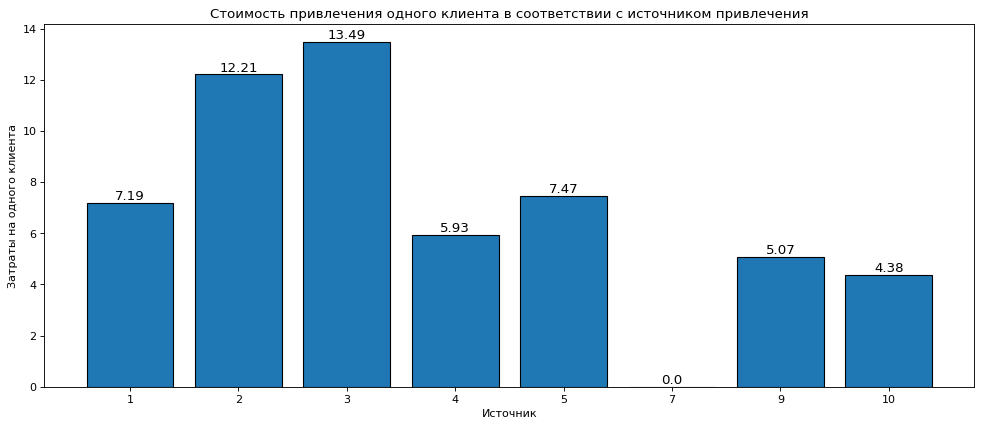

In [136]:
make_graf('Стоимость привлечения одного клиента в соответствии с источником привлечения',costs_of_source['source_id'],
          costs_of_source['cost_per_customer'],"Затраты на одного клиента")

In [111]:
costs_revenue_of_source['revenue']=costs_revenue_of_source['revenue'].round(2)

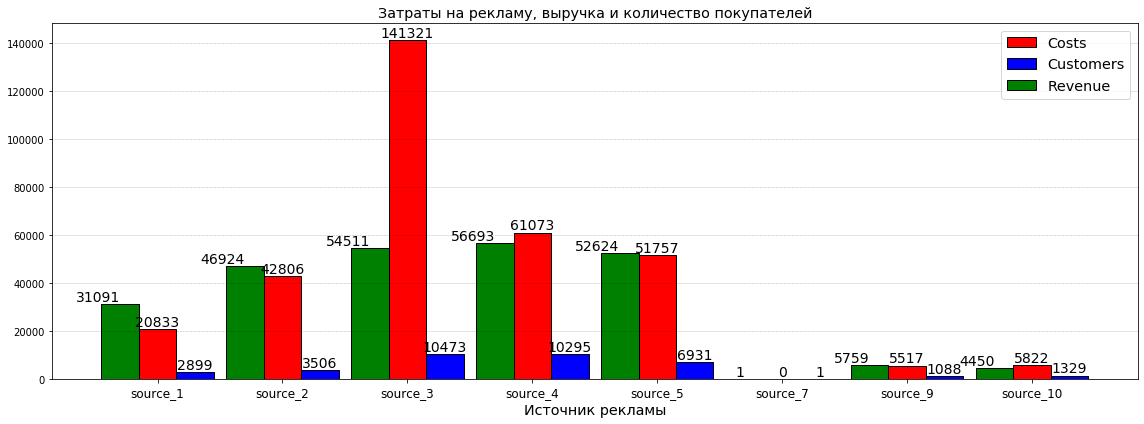

In [138]:
length = len(costs_of_source)
x_labels =['source_1', 'source_2', 'source_3', 'source_4', 'source_5', 'source_7','source_9','source_10']
fig, ax = plt.subplots(figsize=(16,6))
width = 0.3 # width of bar
x = np.arange(length)
#строим бар
ax.bar(x, costs_of_source['costs'], width, color='baf1a1', label='Costs',ec='black' )
#делаем подписи
for i, val in enumerate(costs_of_source['costs'].values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom',fontdict={'fontweight':500, 'size':14})
ax.bar(x + width, orders_pivot_source_id['uid'], width, color='blue', label='Customers',ec='black')
for i, val in enumerate(orders_pivot_source_id['uid'].values):
    plt.text(i+width, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':14})
ax.bar(x - width, costs_revenue_of_source['revenue'], width, color='green', label='Revenue',ec='black' )
for i, val in enumerate(costs_revenue_of_source['revenue'].values):
    plt.text(i -width, val, int(val),horizontalalignment='right', verticalalignment='bottom', fontdict={'fontweight':500, 'size':14})
ax.set_xticks(x)
ax.set_xticklabels(x_labels,fontsize='large')
ax.set_xlabel('Источник рекламы',fontsize='x-large')
ax.set_title('Затраты на рекламу, выручка и количество покупателей',fontsize='x-large')
ax.legend(fontsize='x-large')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
fig.tight_layout()
plt.show()

Анализируем график:
* наиболее затратный рекламный канал source_3, создается ощущение, что он неокупится никогда. 
Маркетологам стоит обратить на этот канал внимание (пора завязывать вливать туда такое количество денег). Есть один плюс, он привел больше всего пользователей, но выручка от них почти такая же, как и от пользователей которые пришли по источнику source_2, хотя их в три раза меньше.
* самый эффективный канал это source_1.
* нужно диверсифицировать ресурсы в неубыточные и эффективные каналы, такие как source_1, source_9 - уникален тем, что приносит дешевле всех копупателей и неубыточный!

<a name="2.3.3"></a><br/>
<font size="4"><b> 2.3.3 На сколько окупились расходы? (ROI)</b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

ROI (Return on Investment) или ROMI (Return on marketing investment) –  ROMI показывает, какой возврат вы получите на вложение денег в определенный канал привлечения. 
Для того, чтобы посчитать ROMI для канала нужно: 
1. Выделить период за который мы будем делать подсчет (возьмем 6 месяцев)
2. Определить средне-валовую прибыль на клиента в разрезе источников прихода ['ltv']
3. Определить среднюю стоимость затрат на привлечение клиента по источникам привлечения ['cac']
4. Подделить одно на другое [ROMI]= ['ltv']/['cac']
5. Если ROMI>1 то инвестиции окупились, меньше - нет.

In [113]:
# делаем срез по заказам по клиентам, которые прожили минимум 6 месяцев.
# uid_who_lived_6months считали выше как 
# uid_who_lived_6months=orders.query('cohort_lifetime<7 & first_order_month<="2017-11-01T00:00:00.000000000"')['uid'].unique().tolist()
orders_6months=orders.query('cohort_lifetime<=6 & uid==@uid_who_lived_6months')
orders_6months.tail(1)

,buy_ts,revenue,uid,first_visit_of_user,time_for_buying_from_first_visit,epic_fail,order_year,order_month,order_week_week,order_date,first_order_date,first_order_month,cohort_lifetime,n_buyers
25318,2017-11-30 23:52:00,4.34,15488282075441611372,2017-11-30 23:05:00,2820,False,2017-01-01,2017-11-01,48,2017-11-30,2017-11-30 23:52:00,2017-11-01,0,4081


In [114]:
# формируем таблицу клиент и выручка
ord_6months=orders_6months.groupby('uid').agg({'revenue':'sum'}).reset_index()
ord_6months.tail(1)

,uid,revenue
16317,18446167067214817906,7.94


In [115]:
#делаем срез таблицы orders_pivot оставляем только клиентов из кагорт которые прожили 6 месяцев
orders_6months_pivot=orders_pivot.query('uid==@uid_who_lived_6months').reset_index()
del orders_6months_pivot['revenue']
del orders_6months_pivot['index']
orders_6months_pivot.tail(1)

,uid,first_order_date,start_ts,source_id
16317,18446167067214817906,2017-10-17 10:16:00,2017-10-17 10:05:00,5


In [116]:
orders_6months_pivot=orders_6months_pivot.merge(ord_6months,on='uid')
orders_6months_pivot.tail(1)

,uid,first_order_date,start_ts,source_id,revenue
16317,18446167067214817906,2017-10-17 10:16:00,2017-10-17 10:05:00,5,7.94


In [117]:
# группируем информациюв отчет rep_new
rep_new=orders_6months_pivot.groupby('source_id').agg({'uid':'nunique','revenue':'sum'}).reset_index()
rep_new.rename(columns={'uid':'count_of_uid'},inplace=True)
rep_new

,source_id,count_of_uid,revenue
0,1,1354,17086.84
1,2,1581,20136.59
2,3,4636,26908.02
3,4,4207,27365.30
4,5,3394,34060.45
5,7,1,1.22
6,9,539,3321.90
7,10,606,2086.37


In [118]:
# делаем срез по тратам на первые 6 месяцев вложений
costs_6months=costs.query('month<="2017-11-01T00:00:00.000000000"')
costs_6months.head(1)

,source_id,date,costs,month
0,1,2017-06-01,75.2,2017-06-01


In [119]:
costs_6months.groupby('source_id').agg({'costs':'sum'})

,costs
source_id,
1,9413.22
2,19649.88
3,64275.69
4,27263.81
5,23741.42
9,2544.90
10,2756.88


In [120]:
# добавляем косты в отчет
rep_new=rep_new.merge(costs_6months.groupby('source_id').agg({'costs':'sum'}),on='source_id')
rep_new

,source_id,count_of_uid,revenue,costs
0,1,1354,17086.84,9413.22
1,2,1581,20136.59,19649.88
2,3,4636,26908.02,64275.69
3,4,4207,27365.30,27263.81
4,5,3394,34060.45,23741.42
5,9,539,3321.90,2544.90
6,10,606,2086.37,2756.88


In [121]:
# добавляем остаальные столбцы
margin_rate = 0.5
rep_new['cac']=rep_new['costs']/rep_new['count_of_uid']
rep_new['gp'] = rep_new['revenue'] * margin_rate
rep_new['ltv'] = rep_new['gp'] / rep_new['count_of_uid']
rep_new['romi'] = (rep_new['ltv'] / rep_new['cac']).round(2)
rep_new

,source_id,count_of_uid,revenue,costs,cac,gp,ltv,romi
0,1,1354,17086.84,9413.22,6.952157,8543.420,6.309764,0.91
1,2,1581,20136.59,19649.88,12.428767,10068.295,6.368308,0.51
2,3,4636,26908.02,64275.69,13.864472,13454.010,2.902073,0.21
3,4,4207,27365.30,27263.81,6.480582,13682.650,3.252353,0.50
4,5,3394,34060.45,23741.42,6.995115,17030.225,5.017745,0.72
5,9,539,3321.90,2544.90,4.721521,1660.950,3.081540,0.65
6,10,606,2086.37,2756.88,4.549307,1043.185,1.721427,0.38


Text(0, 0.5, 'romi')

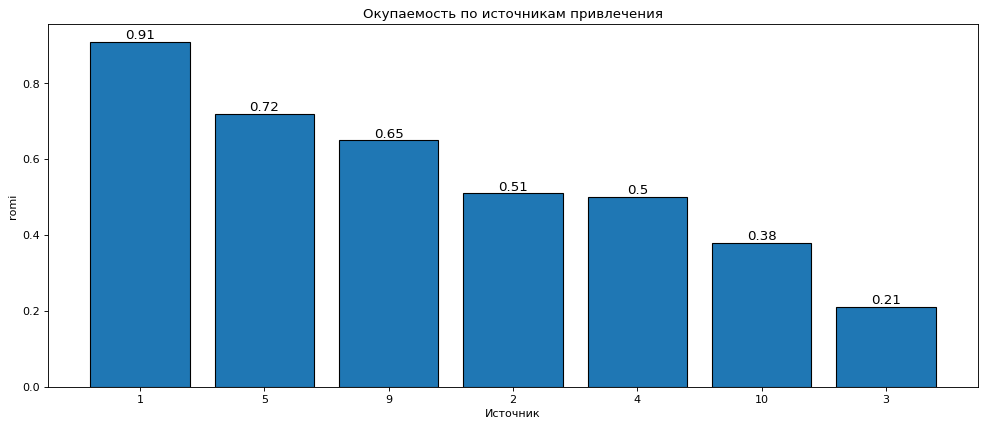

In [139]:
# сортировка
romi=rep_new[['source_id','romi']].sort_values('romi',ascending = False)
romi['source_id']=romi['source_id'].astype(str)
# график
plt.figure(figsize=(15,6), dpi= 80)
plt.bar(romi['source_id'], romi['romi'],ec='black' ) 
for i, val in enumerate(romi['romi'].values):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.title('Окупаемость по источникам привлечения')
plt.gca().set_xticklabels(romi['source_id'])
plt.xlabel('Источник')
plt.ylabel("romi")

##### Как видим, за 6месяцев ни один из источников не окупился. Перспективность источников мы определили пунктом выше опираясь на принесенную выручку, лишь остается повторится source_1, source_5, source_9, то куда стоит диверсифицировать средства. Забыть о source_3.

<a name="2.3.4"></a><br/>
<font size="4"><b> 2.3.4 Анализ платформ</b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

In [126]:
list_of_platform=actual_visits['device'].unique().tolist()
print('У нас есть следующие платформы',list_of_platform)
print('Количество визитов покупателей с плаформы',list_of_platform[0],'равно',len(actual_visits[actual_visits['device']==list_of_platform[0]]))
print('Количество визитов покупателей с плаформы',list_of_platform[1],'равно',len(actual_visits[actual_visits['device']==list_of_platform[1]]))
print('Количество визитов покупателей с плаформы',list_of_platform[0],'больше в {:.1f} раза, чем визитов с платформы'.format(len(actual_visits[actual_visits['device']==list_of_platform[0]])/len(actual_visits[actual_visits['device']==list_of_platform[1]])),list_of_platform[1])

У нас есть следующие платформы ['desktop', 'touch']
Количество визитов покупателей с плаформы desktop равно 78158
Количество визитов покупателей с плаформы touch равно 19236
Количество визитов покупателей с плаформы desktop больше в 4.1 раза, чем визитов с платформы touch


Посмотрим как распределены визиты по платформам.

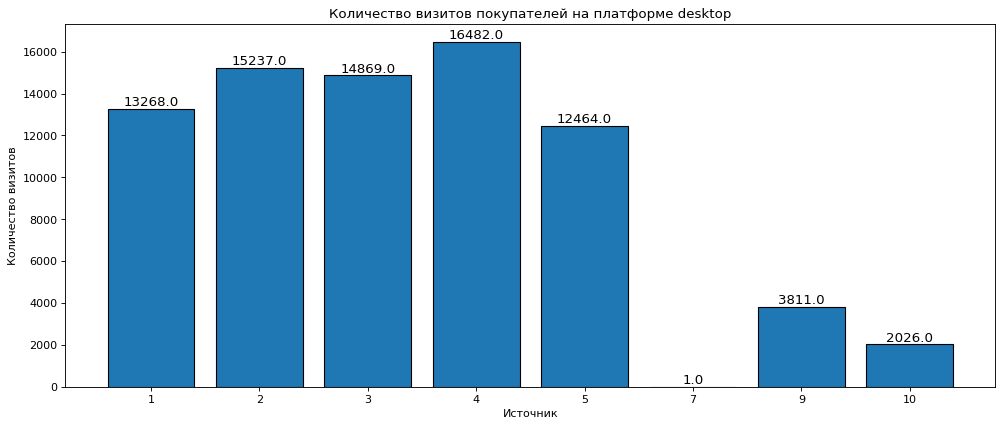

In [140]:
visit_by_device=actual_visits.query('device=="desktop"').groupby(['source_id']).agg({'uid':'count'}).reset_index()
visit_by_device['source_id']=visit_by_device['source_id'].astype('str')
make_graf('Количество визитов покупателей на платформе desktop',visit_by_device['source_id'],visit_by_device['uid'],'Количество визитов')

На десктопах происходит больше всего заходов покупателей по источнику source_4.
Визиты на десктопах по source_1-5 примерно одинаковы.

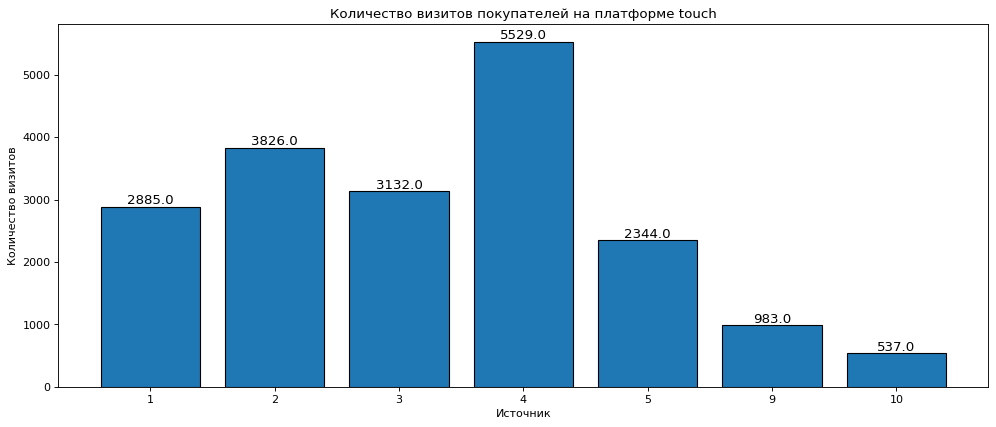

In [141]:
visit_by_device=actual_visits.query('device=="touch"').groupby(['source_id']).agg({'uid':'count'}).reset_index()
visit_by_device['source_id']=visit_by_device['source_id'].astype('str')
make_graf('Количество визитов покупателей на платформе touch',visit_by_device['source_id'],visit_by_device['uid'],'Количество визитов')

На тач устройствах как и на десктопах происходит больше всего заходов покупателей по источнику source_4.
Почти в два раза опережает ближайшего приследователя source_2.

#### в самом начале мы вычислили  на каком визите была совершена первая покупка 68.9% было совершено на первом визите, узнаем что это были за платформы, с разбивкой по источнику прихода.

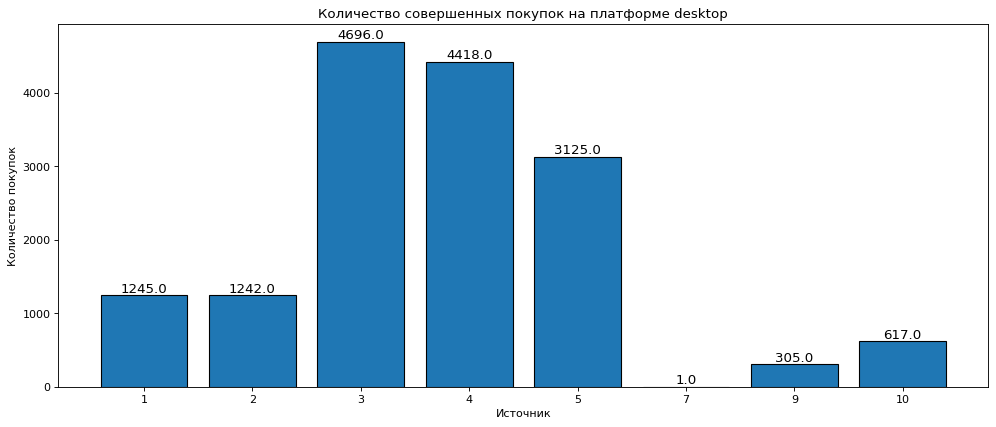

In [142]:
desktop=(actual_visits_true_orders.query('first_order=="True" & number_of_visit==1 & device=="desktop"').groupby('source_id').agg({'uid':'nunique'})).reset_index()
desktop['source_id']=desktop['source_id'].astype('str')
make_graf('Количество совершенных покупок на платформе desktop',desktop['source_id'],desktop['uid'],'Количество покупок')

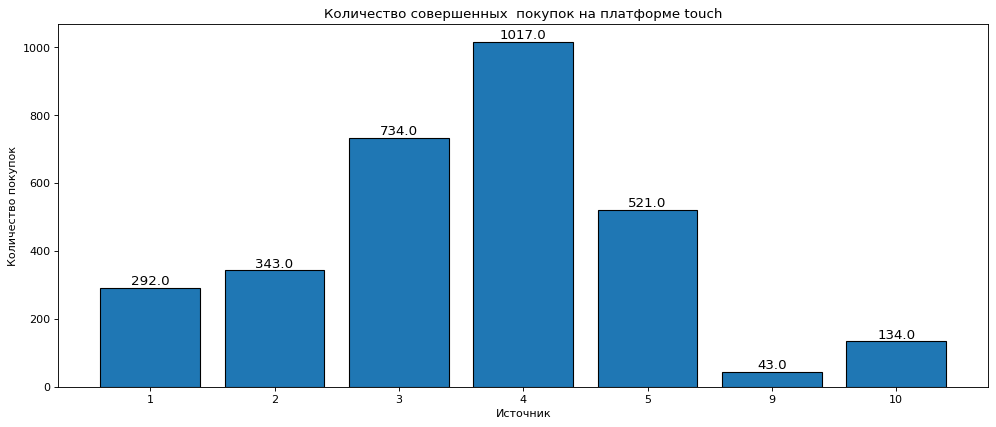

In [143]:
touch=(actual_visits_true_orders.query('first_order=="True" & number_of_visit==1 & device=="touch"').groupby('source_id').agg({'uid':'nunique'})).reset_index()
touch['source_id']=touch['source_id'].astype('str')
make_graf('Количество совершенных  покупок на платформе touch',touch['source_id'],touch['uid'],'Количество покупок')

<a name="3."></a><br/>
<font size="4"><b>3. Общий вывод:</b></font>.<br/>
<font size="2">([к содержанию](#0.0))</font><br/>

1. Анализируя дата фреймы обнаружено в таблицы orders 34% заказов осуществляются вне сессии. Об этой проблеме надо сообщить разработчикам.
2. Отчетливо видна динамика снижения количества возврата пользователей от месяца к месяцу.
3. Также большая часть покупателей 68.9% делает свою покупку в первый свой визит.
4. Нужно учесть при тратах на рекламу, что август мертвый месяц, а наибольшее количество заказов в декабре.
5. Наиболее затратный рекламный канал source_3, создается ощущение, что он неокупится никогда. Маркетологам стоит обратить на этот канал внимание (пора завязывать вливать туда такое количество денег). Есть один плюс, он привел больше всего пользователей, но выручка от них почти такая же, как и от пользователей, которые пришли по источнику source_2, хотя их в три раза меньше.
6. При марже 50% за год не окупились ни одни затраты на источник привлечения.
7. Самый эффективный канал это source_1.
8. Нужно диверсифицировать ресурсы в быстро окупаемые на фоне других и эффективные каналы, такие как source_1,source_2 и source_9. Последний уникален тем, что приносит дешевле всех копупателей и окупаемый в перспективе.
9. Покупок с десктопов в 4раза больше, чем с тач устроиств. Возможно проблемы с мобильной версией сайта или приложением.

In [131]:
(time.time()-start_1)/60

24.23575226465861